# Mar-10-2021

**Motivation**: Correlation/network analysis on Ca data.  Simple network measures and (non-overlapping) community detection.<br>

In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from tqdm.notebook import tqdm

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# Louvain
import community as community_louvain


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [2]:
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm

import community
import matplotlib.pyplot as plt


def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def plot_graph(g, partition):
    # if partition is None: partition = community.best_partition(g, resolution=1.0)
    pos = community_layout(g, partition)

    plt.figure(figsize=(8, 6))
    plt.axis('off')
    nx.draw_networkx_nodes(
        g, pos, node_size=130, edgecolors='k', cmap='Accent', node_color=list(partition.values()))
    nx.draw_networkx_edges(g, pos, alpha=0.2)

    plt.tight_layout()
    plt.show()
    
    return


## Simple analysis

I choose a dataset that looks OK from subject named **sub-SLC08**.

In [5]:
# HIDE CODE


expt_seconds = 600   # 600 seconds
ca_frequency = 10
exclude_seconds = 50
good_timepoints = (expt_seconds - exclude_seconds) * ca_frequency

filter_fn = lambda x: 'ca' in x and 'ses-1' in x and 'sub-SLC06' in x and 'rest' in x
files = sorted(list(filter(filter_fn, os.listdir(processed_dir))))

data_list = []
for load_filename in files:
    ca = np.load(pjoin(processed_dir, load_filename), mmap_mode='r')
    data_list.append(ca[..., 0, range(ca.shape[-1] - good_timepoints, ca.shape[-1])])
ca = np.concatenate(data_list, axis=-1)

files, ca.shape

(['sub-SLC06_ses-1_run-1_task-rest_ca.npy',
  'sub-SLC06_ses-1_run-3_task-rest_ca.npy',
  'sub-SLC06_ses-1_run-5_task-rest_ca.npy',
  'sub-SLC06_ses-1_run-7_task-rest_ca.npy'],
 (256, 250, 22000))

---
More errors in processing
---


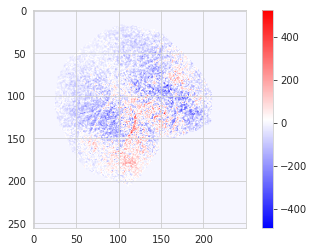

In [7]:
plt.imshow(ca[..., 10090], cmap='bwr')
plt.colorbar()

In [8]:
np.unravel_index(np.argmin(ca), ca.shape)

(139, 117, 1358)

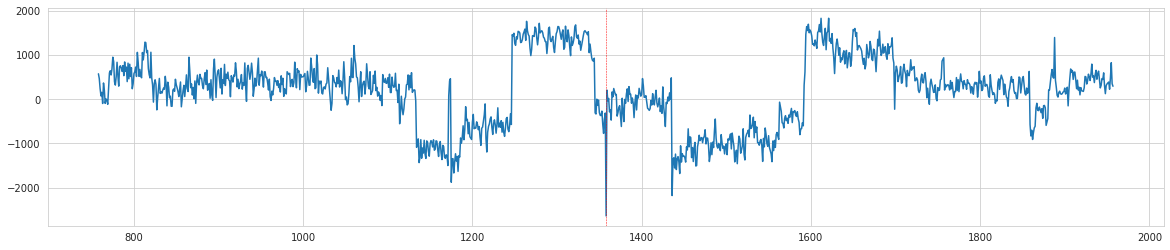

In [10]:
intvl = range(1358 - 600, 1358 + 600)

plt.figure(figsize=(20, 4))
plt.plot(intvl, ca[139, 117, intvl])
plt.axvline(1358, color='red', ls='--', lw=0.5)

---

### Correlation analysis

Take a source signal from one of the "voxels" and compute its correlation with every other point. We should not call these voxels because this is different than fMRI data.  But then if not voxels, what should we call them for Ca data?

Anyway, I take signal from point (128, 128) on cortex surface and compute its correlation with every other point.  Here is how this correlation result looks like.

In [14]:
bad_x_indices = np.where(ca.mean(-1).mean(1) == 0)[0]
bad_y_indices = np.where(ca.mean(-1).mean(0) == 0)[0]

In [15]:
ca_reduced = np.delete(np.delete(ca, bad_y_indices, axis=1), bad_x_indices, axis=0)
ca.shape, ca_reduced.shape

((256, 250, 22000), (190, 186, 22000))

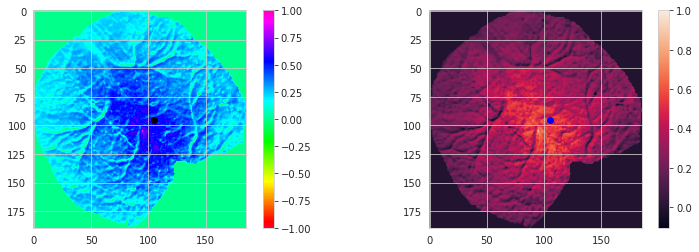

In [16]:
# HIDE CODE


source = (105, 95)
corrs = np.zeros(ca_reduced.shape[:-1])

for i in tqdm(range(ca_reduced.shape[0]), leave=False):
    for j in range(ca_reduced.shape[1]):
        r, p = pearsonr(ca_reduced[i, j, :], ca_reduced[source[0], source[1], :])
        if not np.isnan(r):
            corrs[i, j] = r

plt.figure(figsize=(13, 4))

plt.subplot(121)
plt.imshow(corrs, vmin=-1, vmax=1, cmap='gist_rainbow')
plt.plot(source[0], source[1], color='k', marker='o')
plt.colorbar()

plt.subplot(122)
plt.imshow(corrs)
plt.plot(source[0], source[1], color='b', marker='o')
plt.colorbar()
plt.show()

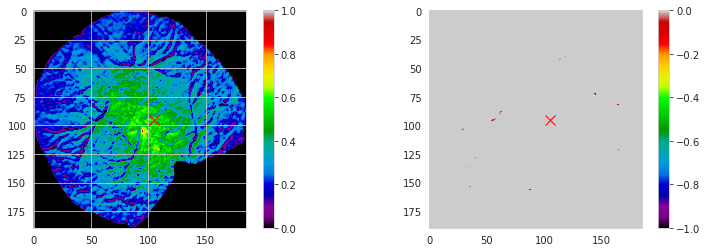

In [18]:
plt.figure(figsize=(13, 4))

plt.subplot(121)
plt.imshow(corrs, vmin=0, vmax=1, cmap='nipy_spectral')
plt.plot(source[0], source[1], color='r', marker='x', markersize=10)
plt.colorbar()

plt.subplot(122)
plt.imshow(corrs, vmin=-1, vmax=0, cmap='nipy_spectral')
plt.plot(source[0], source[1], color='r', marker='x', markersize=10)
plt.colorbar()
plt.show()

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

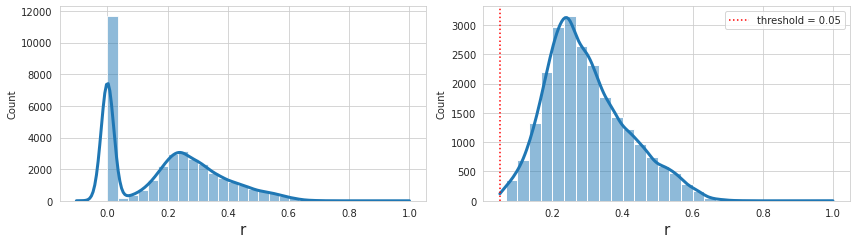

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))

data = corrs.flatten()
bins = np.linspace(0, 1, 31)
threshold = 0.05

sns.histplot(
    data,
    bins=bins,
    stat='count',
    kde=True,
    line_kws={'lw': 3},
    ax=axes[0],
)
sns.histplot(
    data[data>threshold],
    bins=bins[bins>threshold],
    stat='count',
    kde=True,
    line_kws={'lw': 3},
    ax=axes[1],
)
axes[1].axvline(threshold, color='r', ls=':', label='threshold = {}'.format(threshold))
axes[1].legend()

for i in range(2):
    axes[i].set_xlabel('r', fontsize=15)

fig.tight_layout()
plt.show()

### Downsample

In [423]:
size = 16
widths = [int(np.ceil(item / size)) for item in ca_reduced.shape[:2]]
nt = ca_reduced.shape[-1]

downsampled = np.zeros((size, size, nt))
for i in range(size):
    for j in range(size):
        data = ca_reduced[widths[0]*i: widths[0]*(i+1), widths[1]*j: widths[1]*(j+1), :]
        num_nonzero_mean = sum(abs(data).mean(-1).flatten() != 0)
        
        if num_nonzero_mean > 0:
            downsampled[i, j, :] = data.reshape(-1, nt).sum(0) / num_nonzero_mean
        else:
            downsampled[i, j, :] = 0.

downsampled.shape

(16, 16, 22000)

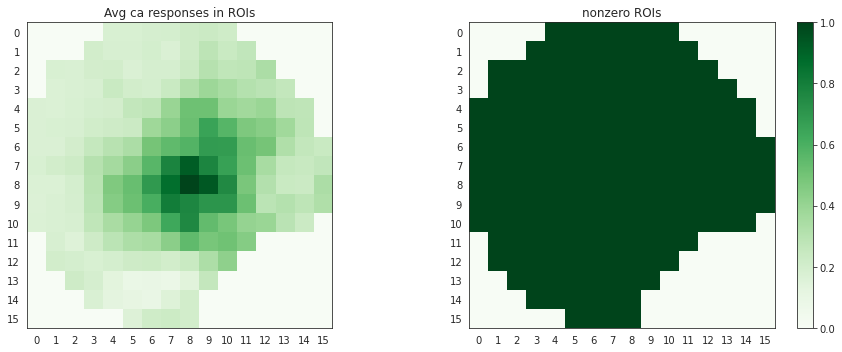

In [424]:
sns.set_style('white')

data = downsampled.mean(-1)

plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.title('Avg ca responses in ROIs')

data[data>0] = 1

plt.subplot(122)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.colorbar()
plt.title('nonzero ROIs')

plt.tight_layout()
plt.show()

In [425]:
df = pd.DataFrame()

for i in tqdm(range(size), leave=False):
    for j in range(size):
        k = '{:d},{:d}'.format(i, j)
        
        if abs(downsampled).mean(-1)[i, j] != 0:
            data_dict = {
                'id': [k] * nt,
                't': np.arange(nt),
                'val': downsampled[i, j],
            }
            df = pd.concat([df, pd.DataFrame.from_dict(data_dict)])

df = df.pivot(index='t', columns='id', values='val')
df = df.reindex(sorted(df.columns, key=lambda x: int(x.split(',')[0]) * 1000 + int(x.split(',')[1])), axis=1)

In [426]:
threshold = 0.0

corr = df.corr()
corr[corr<=threshold] = 0.

In [427]:
corr_np = corr.to_numpy().copy()
# corr_np[corr_np>0] = 1
np.fill_diagonal(corr_np, 0.)
# corr_np = corr_np.astype(int)

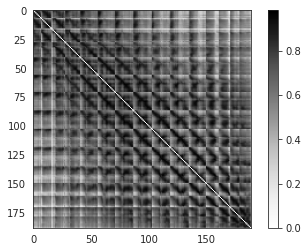

In [428]:
plt.imshow(corr_np, cmap='Greys')
plt.colorbar()

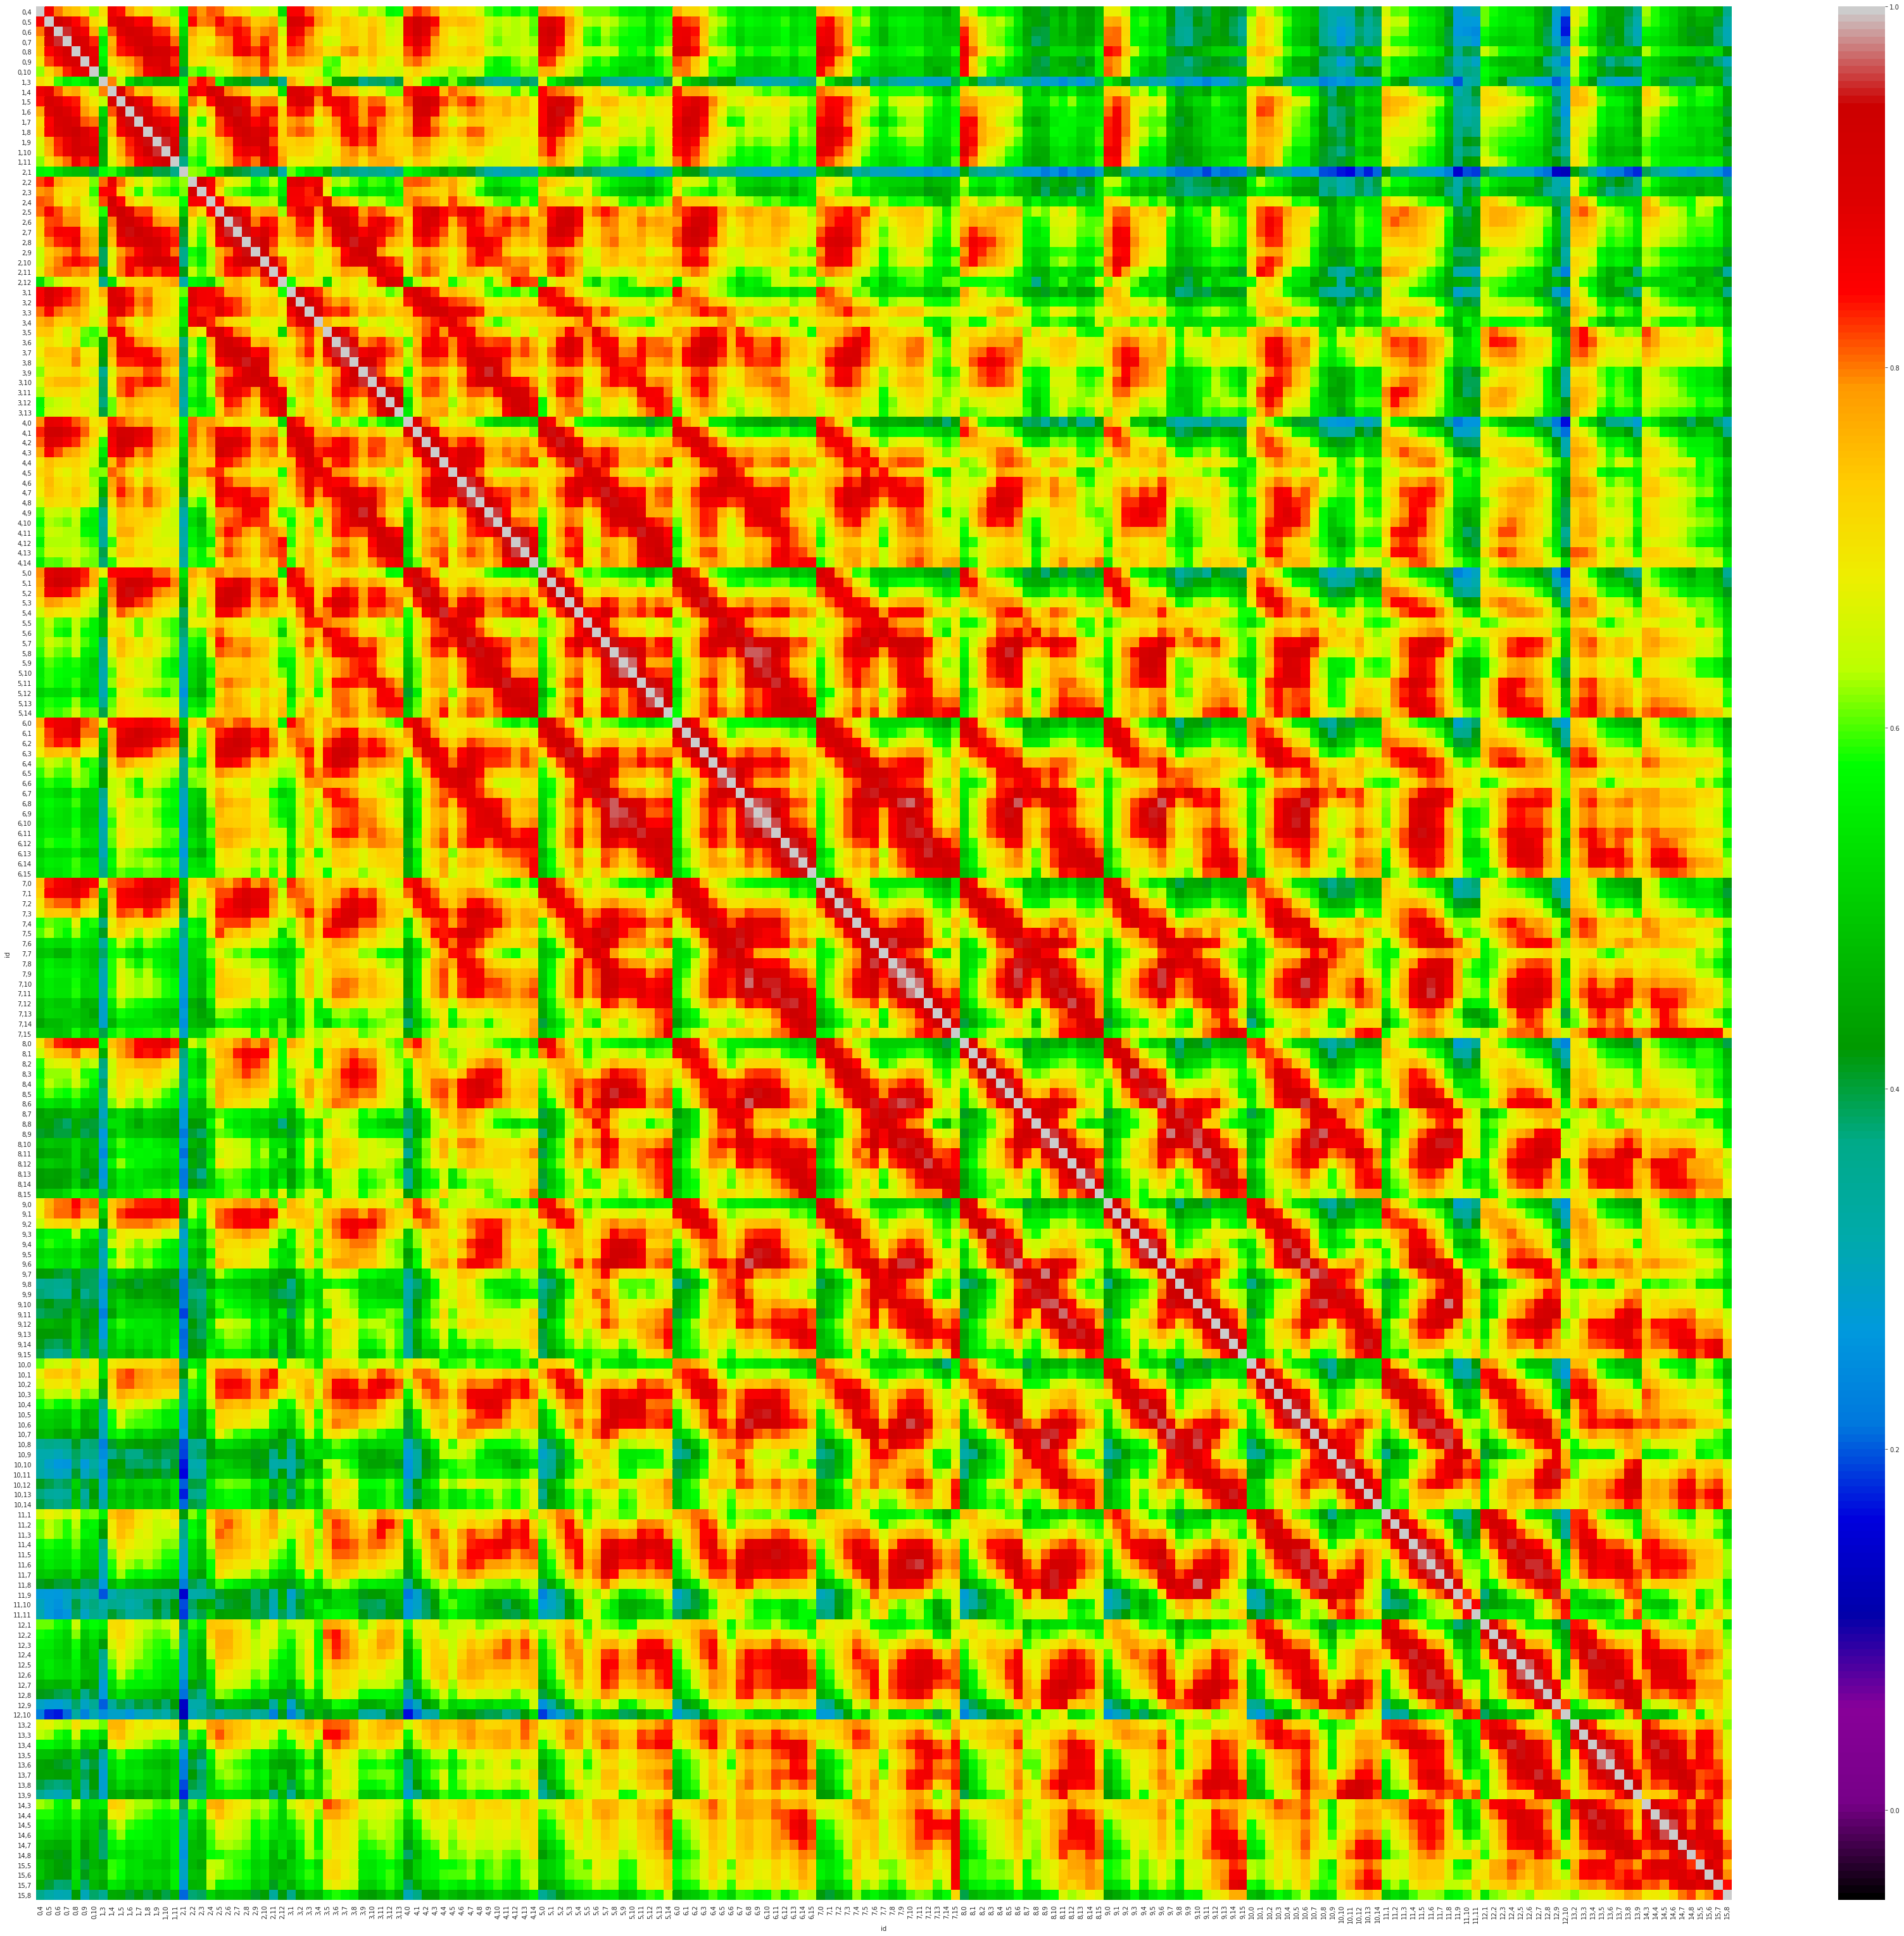

In [429]:
plt.figure(figsize=(60, 55))
sns.heatmap(corr, cmap='nipy_spectral', vmin=threshold-0.05, vmax=1., cbar_kws={'aspect': 40})
plt.yticks(rotation=0);

In [430]:
import networkx as nx
import community
import networkx.algorithms.community as nx_comm
from cdlib import algorithms

In [431]:
labels = labels = df.columns.values.tolist()
labels = {i: lbl for i, lbl in enumerate(labels)}
corr_mat = df.corr().values
np.fill_diagonal(corr_mat, 0)

g = nx.from_numpy_matrix(corr_mat)
# g = nx.relabel_nodes(g, mapping=)

In [432]:
for i in range(g.order()):
    for j in range(g.order()):
        print(i, j, g.get_edge_data(i, j))
        if i > 10:
            break

0 0 None
0 1 {'weight': 0.8564795530632898}
0 2 {'weight': 0.8014372286842045}
0 3 {'weight': 0.7565218412715835}
0 4 {'weight': 0.7447136892131618}
0 5 {'weight': 0.6994814880358264}
0 6 {'weight': 0.6219447864538292}
0 7 {'weight': 0.7092705976265747}
0 8 {'weight': 0.8646712499912884}
0 9 {'weight': 0.8385605670224284}
0 10 {'weight': 0.7722812210466731}
0 11 {'weight': 0.7163999804082469}
0 12 {'weight': 0.7285551031409273}
0 13 {'weight': 0.6608892422590252}
0 14 {'weight': 0.6505768115790478}
0 15 {'weight': 0.6166604477821962}
0 16 {'weight': 0.5575609066081423}
0 17 {'weight': 0.8165478527089258}
0 18 {'weight': 0.7873147930109111}
0 19 {'weight': 0.8122860285394148}
0 20 {'weight': 0.8034029932066085}
0 21 {'weight': 0.7334234898259553}
0 22 {'weight': 0.7195313390108251}
0 23 {'weight': 0.6982129673837306}
0 24 {'weight': 0.6400849759054349}
0 25 {'weight': 0.6413230765914388}
0 26 {'weight': 0.6654896773081511}
0 27 {'weight': 0.5296165246387147}
0 28 {'weight': 0.8523295701

7 41 {'weight': 0.7172747583593452}
7 42 {'weight': 0.6570025065808694}
7 43 {'weight': 0.5863718243281159}
7 44 {'weight': 0.5449891963227788}
7 45 {'weight': 0.49089215163876426}
7 46 {'weight': 0.6180895670798058}
7 47 {'weight': 0.5051130582190796}
7 48 {'weight': 0.4509209353839688}
7 49 {'weight': 0.3940570862836849}
7 50 {'weight': 0.36223745127894647}
7 51 {'weight': 0.3354472686370265}
7 52 {'weight': 0.35115157865314217}
7 53 {'weight': 0.34272153075392164}
7 54 {'weight': 0.3965454487274861}
7 55 {'weight': 0.3793374273187723}
7 56 {'weight': 0.6737770905585625}
7 57 {'weight': 0.5643862145854703}
7 58 {'weight': 0.5030918595954625}
7 59 {'weight': 0.45735270049487575}
7 60 {'weight': 0.406372575485999}
7 61 {'weight': 0.476737877910915}
7 62 {'weight': 0.47372310665894013}
7 63 {'weight': 0.37084589364141185}
7 64 {'weight': 0.34895222832628275}
7 65 {'weight': 0.3335568063425293}
7 66 {'weight': 0.311564503187388}
7 67 {'weight': 0.322359814699907}
7 68 {'weight': 0.308128

In [433]:
# run algorithm
communities_louvain = {}
max_k = 1000

for resolution in tqdm(np.logspace(-2, 1, max_k+1), leave=False):
    coms =  algorithms.louvain(g, resolution=resolution) 
    communities_louvain[resolution] = coms.communities

# process results
modularities_louvain = {}
num_communities_louvain = {}

for resolution, coms_list in communities_louvain.items():
    modularities_louvain[resolution] = nx_comm.modularity(g, communities=coms_list)
    num_communities_louvain[resolution] = len(coms_list)

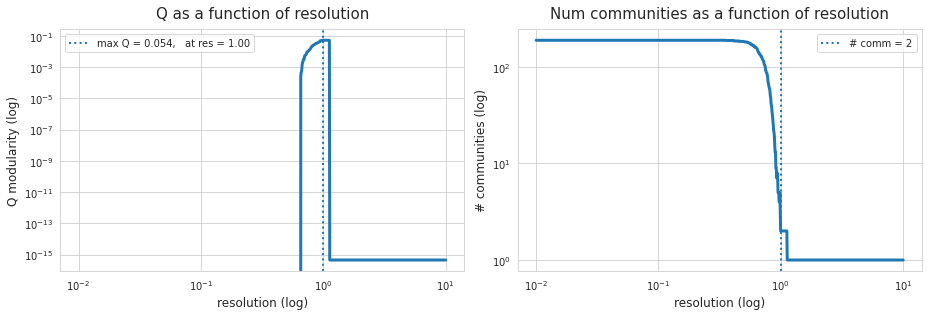

In [437]:
# HIDE CODE


sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')


x0, y0 = tuple(zip(*modularities_louvain.items()))
axes[0].loglog(x0, y0, lw=3)
ls = '--' if k in ['M', 'HM'] else ':'
max_mod_idx = np.argmax(y0)
max_mod = y0[max_mod_idx]
res_at_max_mod = x0[max_mod_idx]
lbl = 'max Q = {:.3f},   at res = {:.2f}'.format(max_mod, res_at_max_mod)
axes[0].axvline(res_at_max_mod, lw=2, ls=ls, label=lbl)

x1, y1 = tuple(zip(*num_communities_louvain.items()))
axes[1].loglog(x1, y1, lw=3)
lbl = '# comm = {:d}'.format(y1[max_mod_idx])
axes[1].axvline(res_at_max_mod, lw=2, ls=ls, label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='upper left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='upper right')

fig.tight_layout()
plt.show()

In [438]:
partition = community.best_partition(g, resolution=1.0, random_state=42)

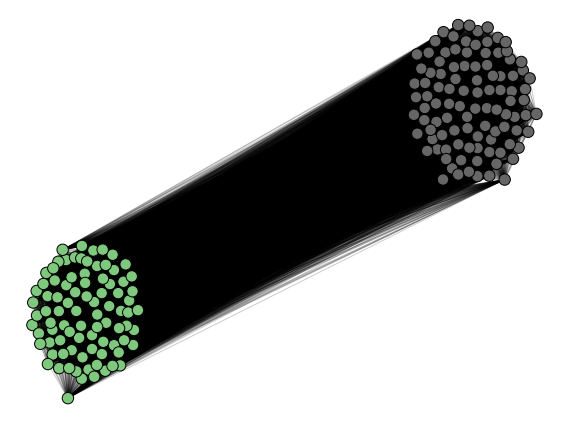

In [439]:
plot_graph(g, partition)

In [440]:
comm_mat = np.ones((size, size))
comm_mat *= -1

for node_idx, lbl in labels.items():
    i, j = tuple(map(lambda x: int(x), lbl.split(',')))
    comm_mat[i, j] = partition[node_idx]

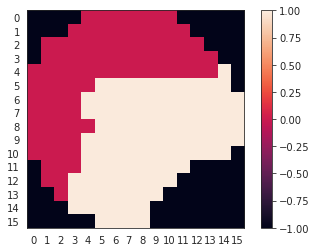

In [441]:
sns.set_style('white')
plt.imshow(comm_mat)
plt.xticks(range(size))
plt.yticks(range(size))
plt.colorbar()

### Threshold

In [443]:
threshold = 0.8

corr = df.corr()
corr[corr<=threshold] = 0.

In [444]:
corr_np = corr.to_numpy().copy()
# corr_np[corr_np>0] = 1
np.fill_diagonal(corr_np, 0.)
# corr_np = corr_np.astype(int)

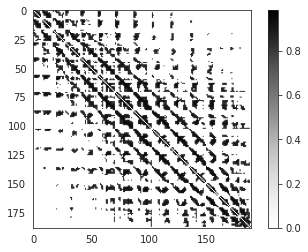

In [445]:
plt.imshow(corr_np, cmap='Greys')
plt.colorbar()

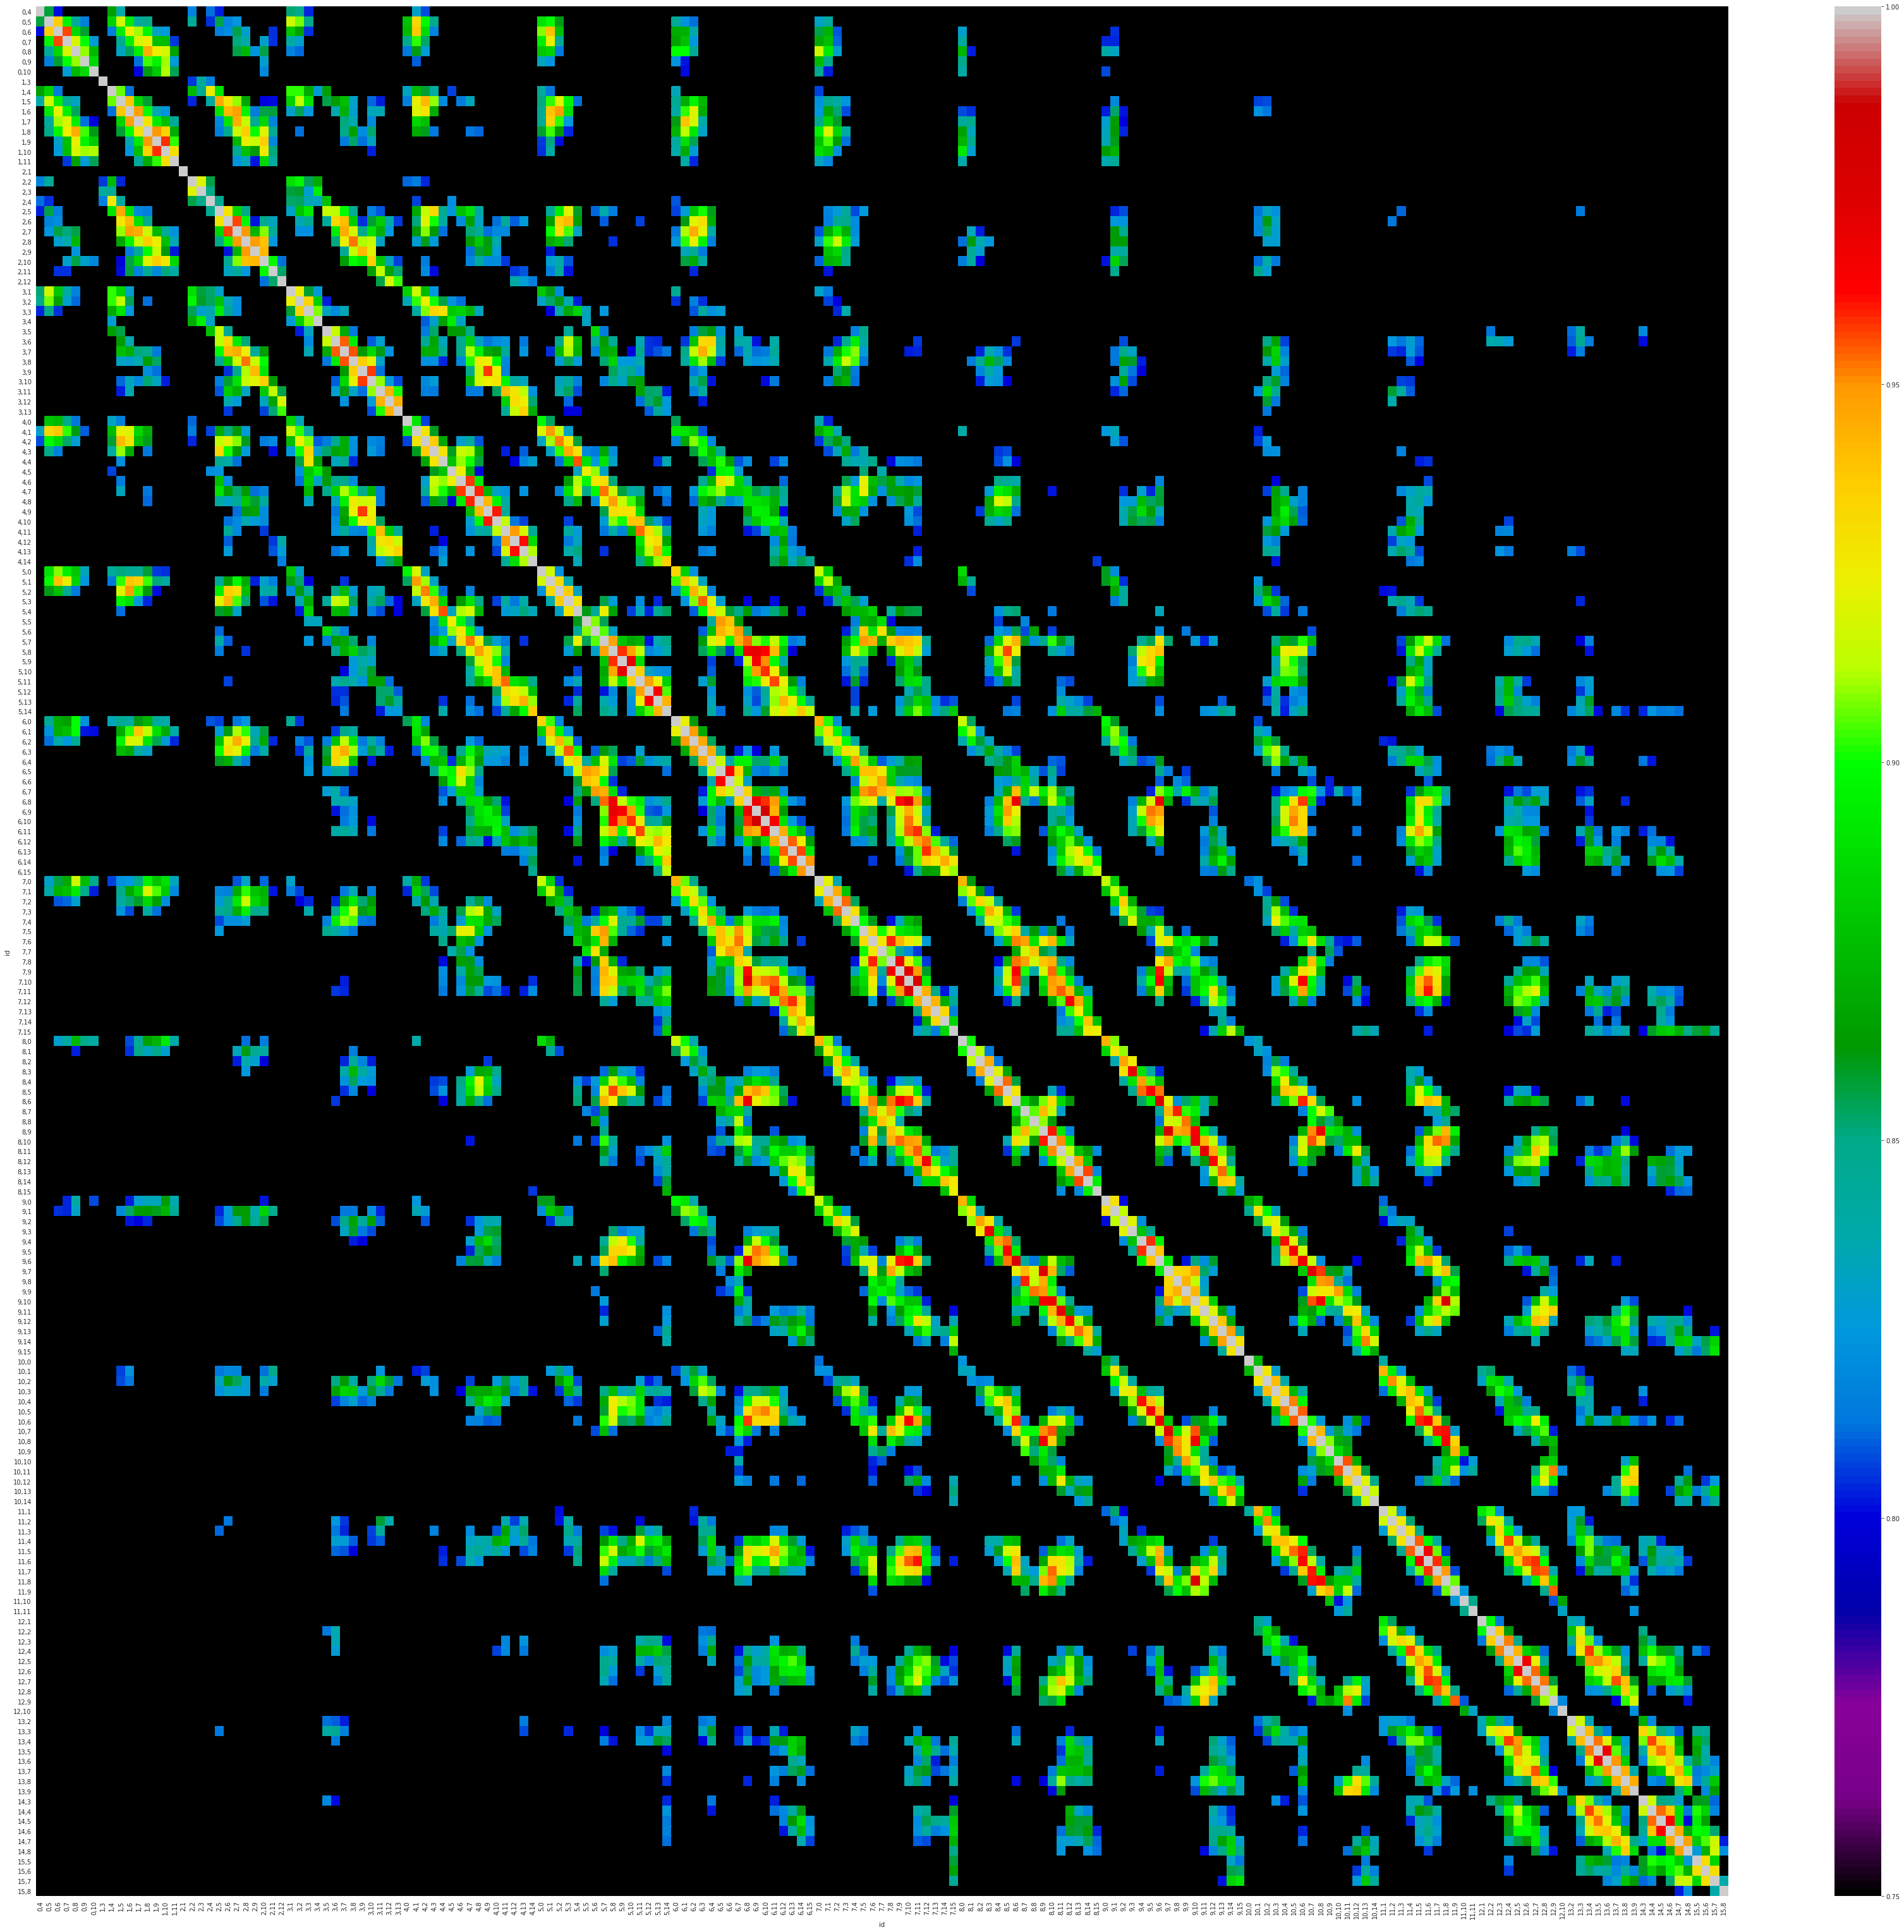

In [446]:
plt.figure(figsize=(60, 55))
sns.heatmap(corr, cmap='nipy_spectral', vmin=threshold-0.05, vmax=1., cbar_kws={'aspect': 40})
plt.yticks(rotation=0);

In [447]:
import networkx as nx
import community
import networkx.algorithms.community as nx_comm
from cdlib import algorithms

In [451]:
labels = labels = df.columns.values.tolist()
labels = {i: lbl for i, lbl in enumerate(labels)}
corr_mat = df.corr().values
corr_mat[corr_mat<threshold] = 0.
np.fill_diagonal(corr_mat, 0.)

g = nx.from_numpy_matrix(corr_mat)
# g = nx.relabel_nodes(g, mapping=)

In [452]:
for i in range(g.order()):
    for j in range(g.order()):
        print(i, j, g.get_edge_data(i, j))
        if i > 10:
            break

0 0 None
0 1 {'weight': 0.8564795530632898}
0 2 {'weight': 0.8014372286842045}
0 3 None
0 4 None
0 5 None
0 6 None
0 7 None
0 8 {'weight': 0.8646712499912884}
0 9 {'weight': 0.8385605670224284}
0 10 None
0 11 None
0 12 None
0 13 None
0 14 None
0 15 None
0 16 None
0 17 {'weight': 0.8165478527089258}
0 18 None
0 19 {'weight': 0.8122860285394148}
0 20 {'weight': 0.8034029932066085}
0 21 None
0 22 None
0 23 None
0 24 None
0 25 None
0 26 None
0 27 None
0 28 {'weight': 0.8523295701102483}
0 29 {'weight': 0.8487241453162815}
0 30 {'weight': 0.8039173803709723}
0 31 None
0 32 None
0 33 None
0 34 None
0 35 None
0 36 None
0 37 None
0 38 None
0 39 None
0 40 None
0 41 None
0 42 {'weight': 0.8304959232998688}
0 43 {'weight': 0.808257860004791}
0 44 None
0 45 None
0 46 None
0 47 None
0 48 None
0 49 None
0 50 None
0 51 None
0 52 None
0 53 None
0 54 None
0 55 None
0 56 None
0 57 None
0 58 None
0 59 None
0 60 None
0 61 None
0 62 None
0 63 None
0 64 None
0 65 None
0 66 None
0 67 None
0 68 None
0 69 None

5 128 None
5 129 None
5 130 None
5 131 None
5 132 None
5 133 None
5 134 None
5 135 None
5 136 None
5 137 None
5 138 None
5 139 None
5 140 None
5 141 None
5 142 None
5 143 None
5 144 None
5 145 None
5 146 None
5 147 None
5 148 None
5 149 None
5 150 None
5 151 None
5 152 None
5 153 None
5 154 None
5 155 None
5 156 None
5 157 None
5 158 None
5 159 None
5 160 None
5 161 None
5 162 None
5 163 None
5 164 None
5 165 None
5 166 None
5 167 None
5 168 None
5 169 None
5 170 None
5 171 None
5 172 None
5 173 None
5 174 None
5 175 None
5 176 None
5 177 None
5 178 None
5 179 None
5 180 None
5 181 None
5 182 None
5 183 None
5 184 None
5 185 None
5 186 None
5 187 None
5 188 None
6 0 None
6 1 None
6 2 None
6 3 {'weight': 0.8280572546105115}
6 4 {'weight': 0.8738421584656259}
6 5 {'weight': 0.8848353175425239}
6 6 None
6 7 None
6 8 None
6 9 None
6 10 None
6 11 {'weight': 0.8002246247741942}
6 12 {'weight': 0.8612261525446626}
6 13 {'weight': 0.8808089182394623}
6 14 {'weight': 0.9117376922343076}
6 15 {'

In [453]:
# run algorithm
communities_louvain = {}
max_k = 1000

for resolution in tqdm(np.logspace(-2, 1, max_k+1), leave=False):
    coms =  algorithms.louvain(g, resolution=resolution) 
    communities_louvain[resolution] = coms.communities

# process results
modularities_louvain = {}
num_communities_louvain = {}

for resolution, coms_list in communities_louvain.items():
    modularities_louvain[resolution] = nx_comm.modularity(g, communities=coms_list)
    num_communities_louvain[resolution] = len(coms_list)

In [562]:
palette = sns.color_palette('autumn', n_colors=4)
palette

[(1.0, 0.2, 0.0), (1.0, 0.4, 0.0), (1.0, 0.6, 0.0), (1.0, 0.8, 0.0)]

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'


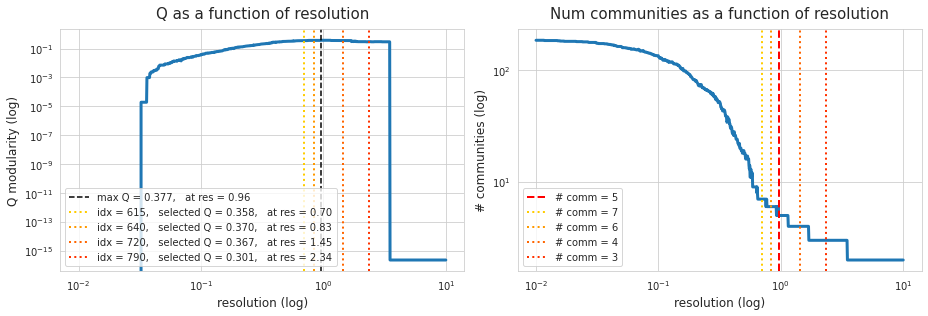

In [594]:
# HIDE CODE


selected_idxs = [615, 640, 720, 790]
palette = sns.color_palette('autumn_r', n_colors=len(selected_idxs))

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')


x0, y0 = tuple(zip(*modularities_louvain.items()))
axes[0].loglog(x0, y0, lw=3)
max_mod_idx = np.argmax(y0)
max_mod = y0[max_mod_idx]
res_at_max_mod = x0[max_mod_idx]
lbl = 'max Q = {:.3f},   at res = {:.2f}'.format(max_mod, res_at_max_mod)
axes[0].axvline(res_at_max_mod, color='k', lw=1.5, ls='--', label=lbl)


for i, _idx in enumerate(selected_idxs):
    lbl = 'idx = {:d},   selected Q = {:.3f},   at res = {:.2f}'.format(_idx, y0[_idx], x0[_idx])
    axes[0].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

x1, y1 = tuple(zip(*num_communities_louvain.items()))
axes[1].loglog(x1, y1, lw=3)
lbl = '# comm = {:d}'.format(y1[max_mod_idx])
axes[1].axvline(res_at_max_mod, color='r', lw=2, ls='--', label=lbl)

for i, _idx in enumerate(selected_idxs):
    lbl = '# comm = {:d}'.format(y1[_idx])
    axes[1].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='lower left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='lower left')

fig.tight_layout()
plt.show()

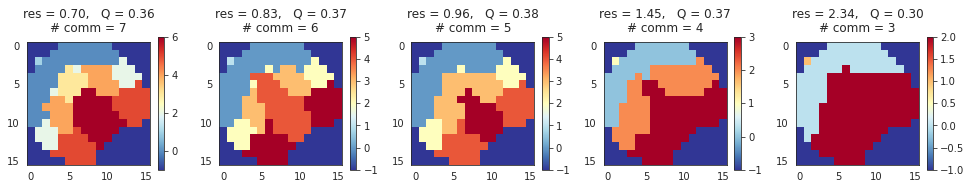

In [595]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(1, len(plot_idxs), figsize=(13.5, 3))

for ii, idx in enumerate(plot_idxs):
    x0, y0 = tuple(zip(*modularities_louvain.items()))
    x1, y1 = tuple(zip(*num_communities_louvain.items()))
    
    partition = community.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat = np.ones((size, size)) * -1
    for node_idx, lbl in labels.items():
        i, j = tuple(map(lambda x: int(x), lbl.split(',')))
        comm_mat[i, j] = partition[node_idx]

    im = axes[ii].imshow(comm_mat, cmap='RdYlBu_r')
    plt.colorbar(im, ax=axes[ii], shrink=0.7)
    msg = 'res = {:.2f},   Q = {:.2f}\n# comm = {:d}'
    msg = msg.format(x0[idx], y0[idx], y1[idx])
    axes[ii].set_title(msg, y=1.03)
    
fig.tight_layout()
plt.show()

### Finer resolution

### Downsample

In [652]:
size = 32
widths = [int(np.ceil(item / size)) for item in ca_reduced.shape[:2]]
nt = ca_reduced.shape[-1]

downsampled = np.zeros((size, size, nt))
for i in range(size):
    for j in range(size):
        data = ca_reduced[widths[0]*i: widths[0]*(i+1), widths[1]*j: widths[1]*(j+1), :]
        num_nonzero_mean = sum(abs(data).mean(-1).flatten() != 0)
        
        if num_nonzero_mean > 0:
            downsampled[i, j, :] = data.reshape(-1, nt).sum(0) / num_nonzero_mean
        else:
            downsampled[i, j, :] = 0.

downsampled.shape

(32, 32, 22000)

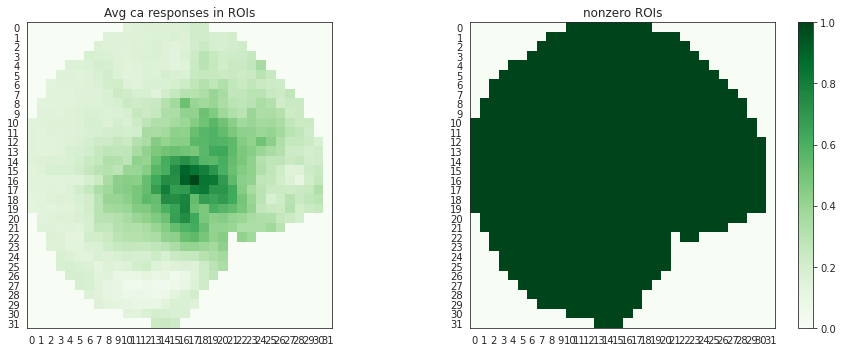

In [653]:
sns.set_style('white')

data = downsampled.mean(-1)

plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.title('Avg ca responses in ROIs')

data[data>0] = 1

plt.subplot(122)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.colorbar()
plt.title('nonzero ROIs')

plt.tight_layout()
plt.show()

In [654]:
df = pd.DataFrame()

downsampled_means = abs(downsampled).mean(-1)
dict_list = []
for i in tqdm(range(size), leave=False):
    for j in range(size):
        k = '{:d},{:d}'.format(i, j)
        
        if downsampled_means[i, j] != 0:
            data_dict = {
                'id': [k] * nt,
                't': np.arange(nt),
                'val': downsampled[i, j],
            }
            dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))
df = df.pivot(index='t', columns='id', values='val')
df = df.reindex(sorted(df.columns, key=lambda x: int(x.split(',')[0]) * 1000 + int(x.split(',')[1])), axis=1)

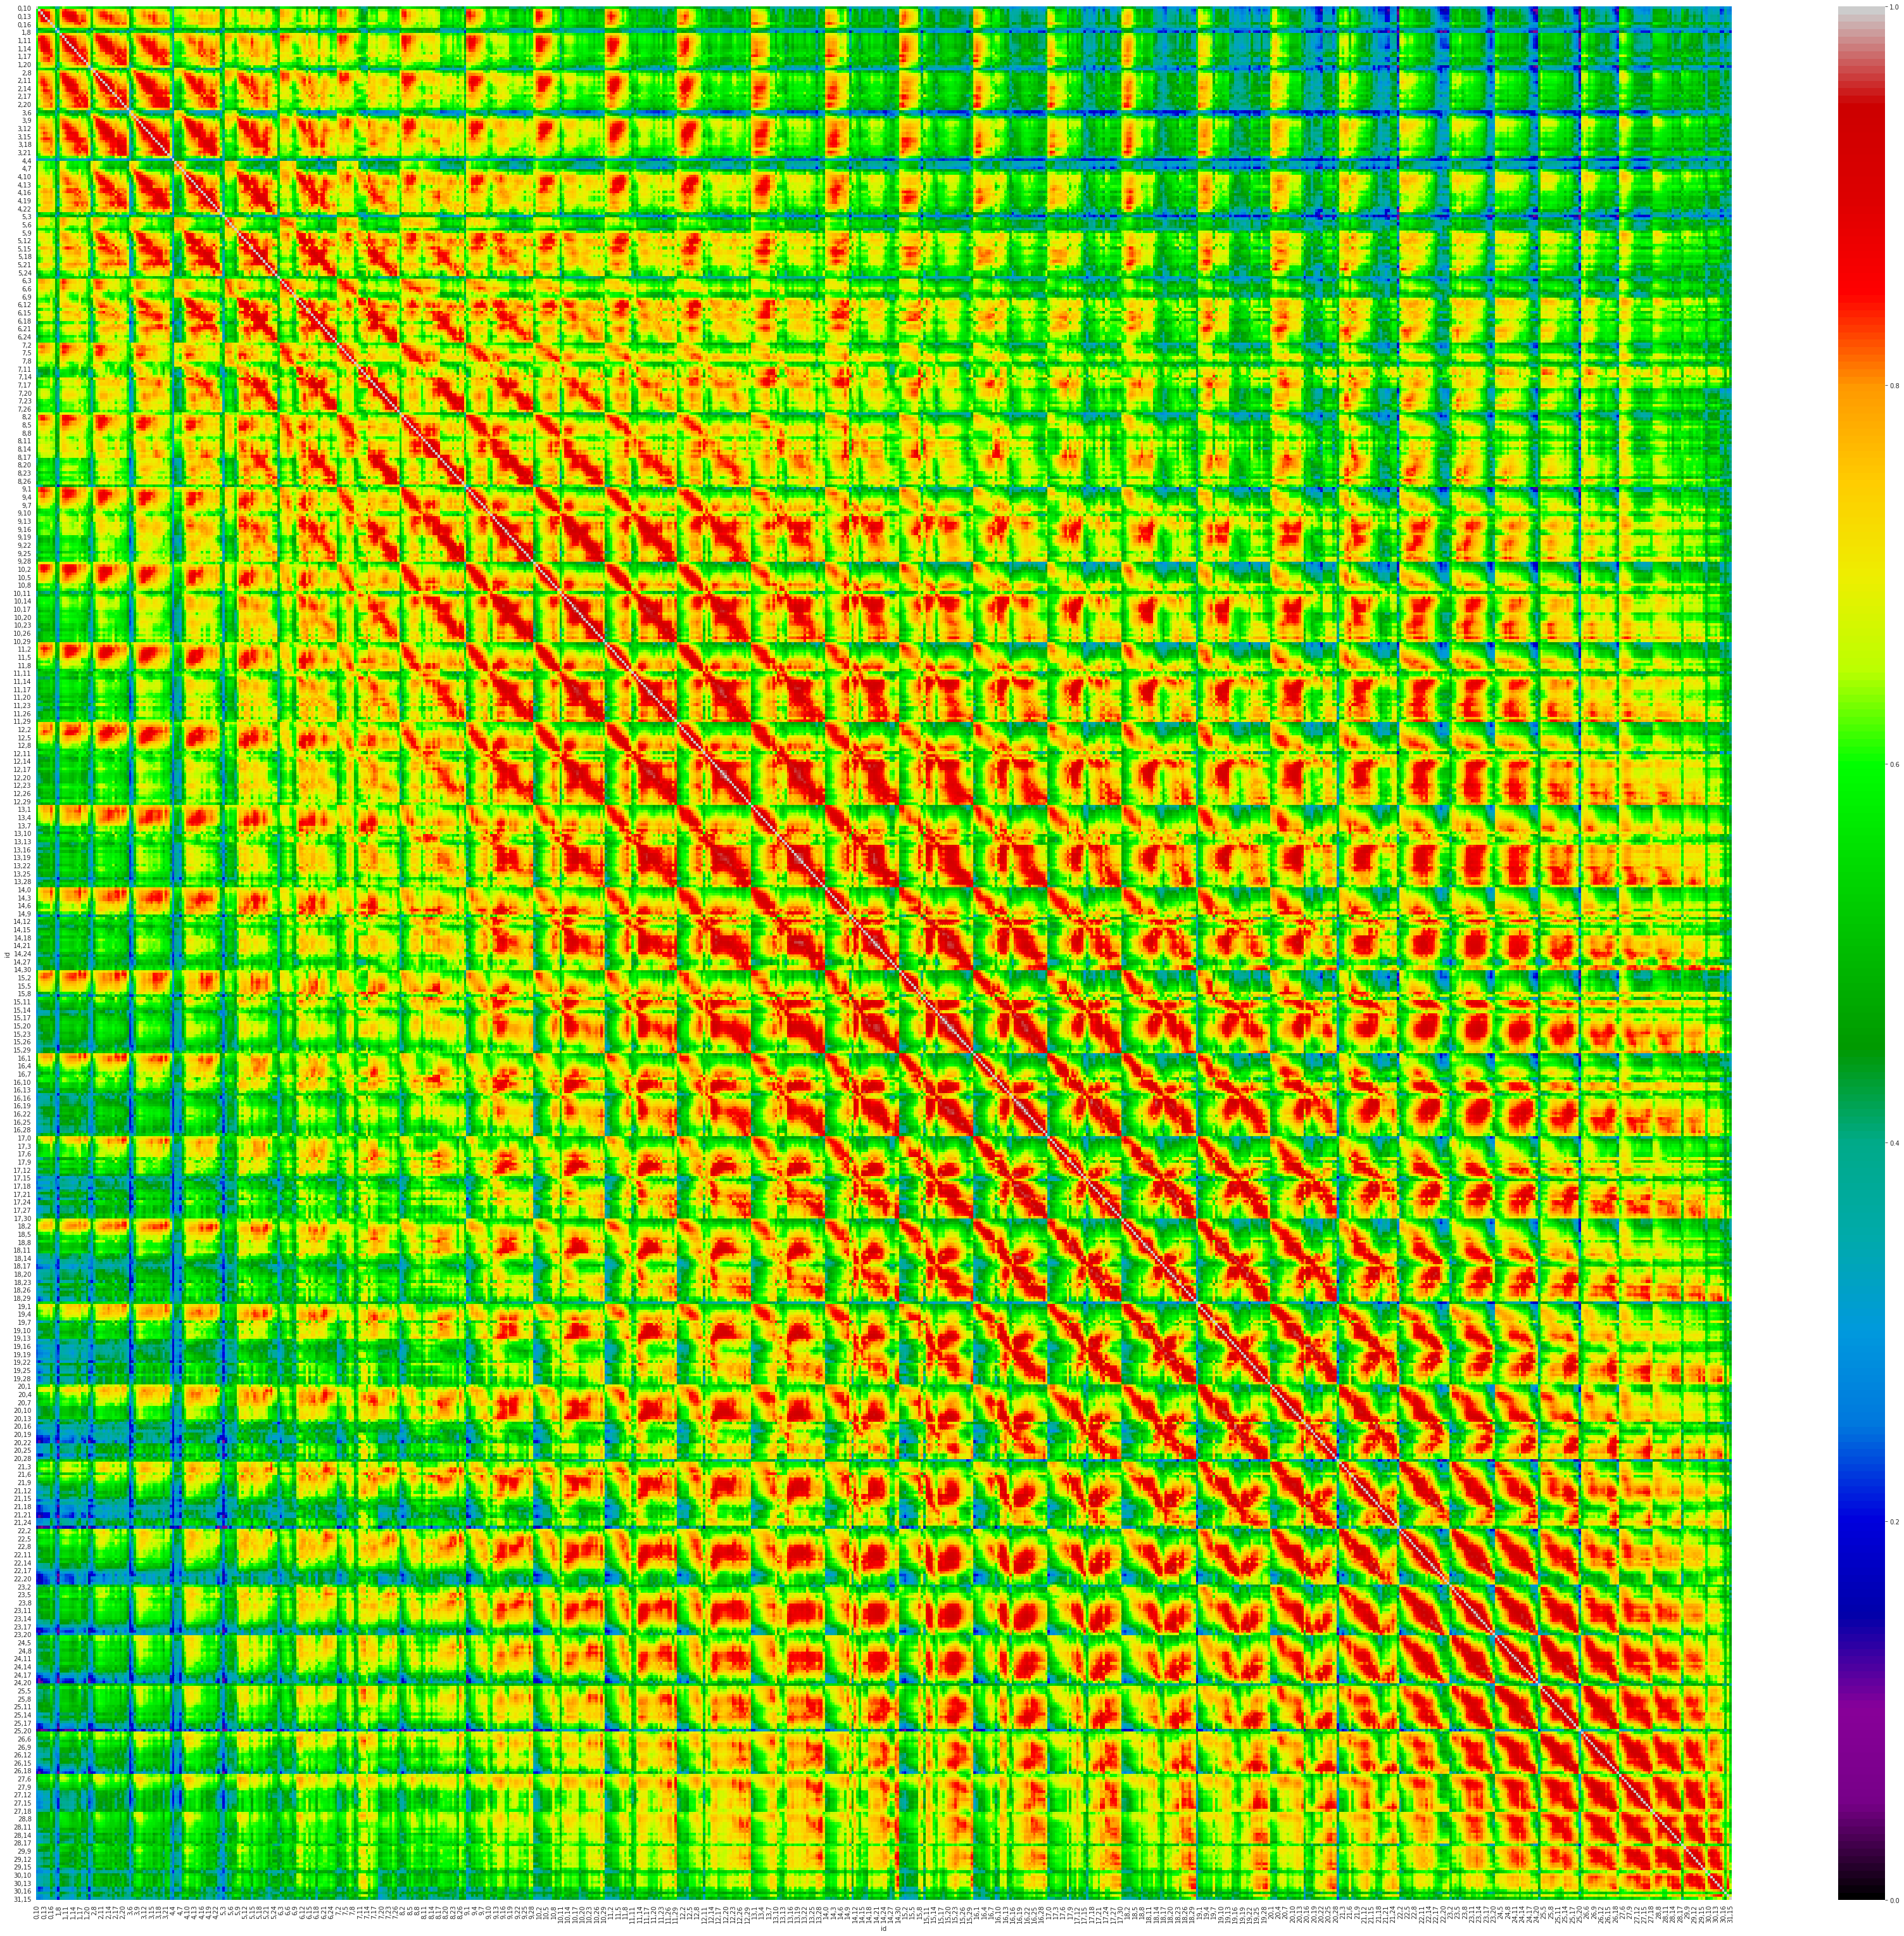

In [655]:
plt.figure(figsize=(60, 55))
sns.heatmap(df.corr(), cmap='nipy_spectral', vmin=0, vmax=1, cbar_kws={'aspect': 40})
plt.yticks(rotation=0);

In [656]:
threshold = 0.8

corr = df.corr()
corr[corr<=threshold] = 0.

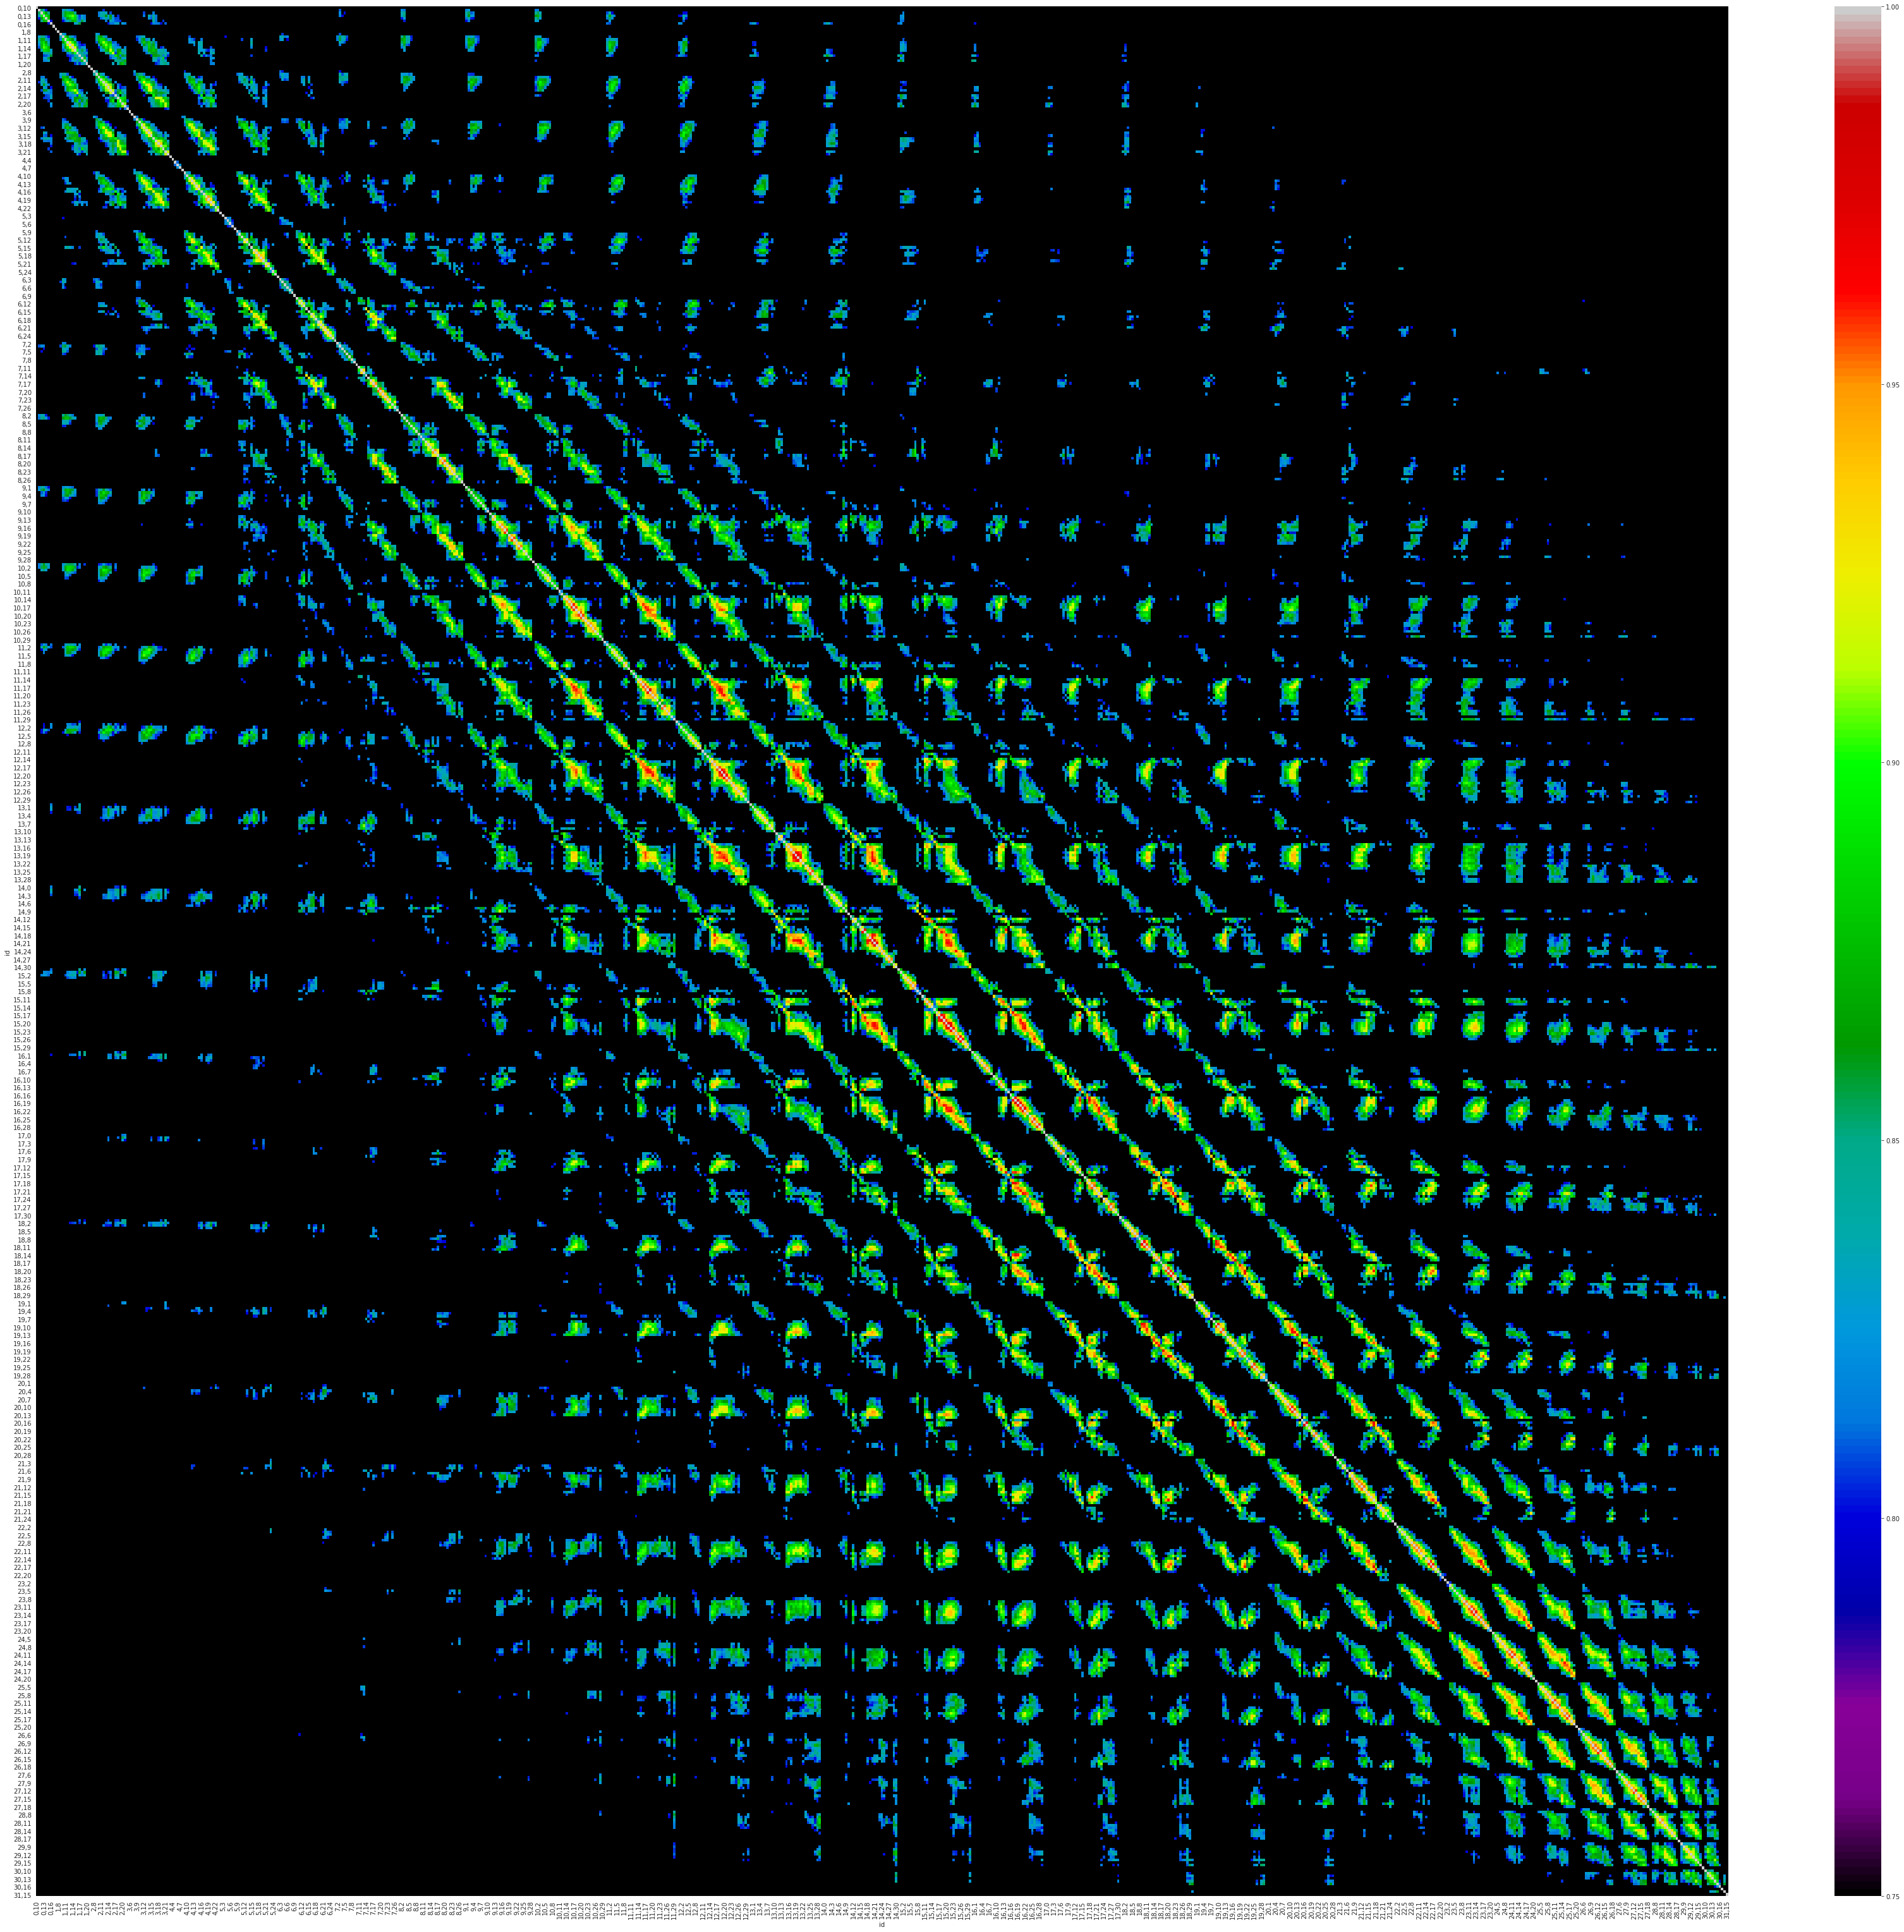

In [657]:
plt.figure(figsize=(60, 55))
sns.heatmap(corr, cmap='nipy_spectral', vmin=threshold-0.05, vmax=1., cbar_kws={'aspect': 40})
plt.yticks(rotation=0);

In [658]:
import networkx as nx
import community
import networkx.algorithms.community as nx_comm
from cdlib import algorithms

In [659]:
labels = labels = df.columns.values.tolist()
labels = {i: lbl for i, lbl in enumerate(labels)}
corr_mat = df.corr().values
corr_mat[corr_mat<threshold] = 0.
np.fill_diagonal(corr_mat, 0.)

g = nx.from_numpy_matrix(corr_mat)
# g = nx.relabel_nodes(g, mapping=)

In [660]:
# run algorithm
communities_louvain = {}
max_k = 1000

for resolution in tqdm(np.logspace(-1, 1, max_k+1), leave=False):
    coms =  algorithms.louvain(g, resolution=resolution) 
    communities_louvain[resolution] = coms.communities

# process results
modularities_louvain = {}
num_communities_louvain = {}

for resolution, coms_list in communities_louvain.items():
    modularities_louvain[resolution] = nx_comm.modularity(g, communities=coms_list)
    num_communities_louvain[resolution] = len(coms_list)

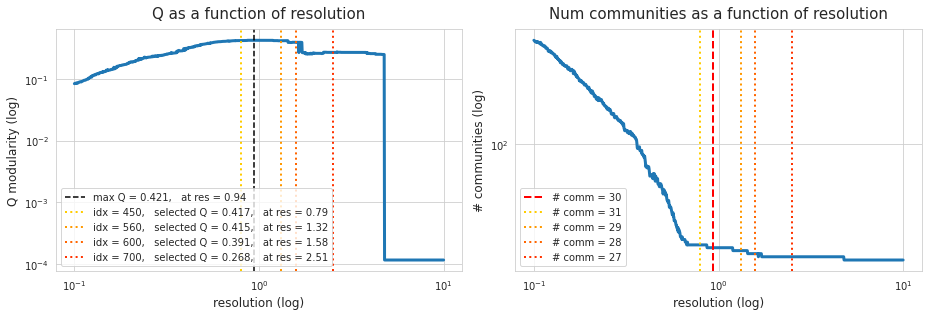

In [667]:
# HIDE CODE


selected_idxs = [450, 560, 600, 700]
palette = sns.color_palette('autumn_r', n_colors=len(selected_idxs))

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')


x0, y0 = tuple(zip(*modularities_louvain.items()))
axes[0].loglog(x0, y0, lw=3)
max_mod_idx = np.argmax(y0)
max_mod = y0[max_mod_idx]
res_at_max_mod = x0[max_mod_idx]
lbl = 'max Q = {:.3f},   at res = {:.2f}'.format(max_mod, res_at_max_mod)
axes[0].axvline(res_at_max_mod, color='k', lw=1.5, ls='--', label=lbl)


for i, _idx in enumerate(selected_idxs):
    lbl = 'idx = {:d},   selected Q = {:.3f},   at res = {:.2f}'.format(_idx, y0[_idx], x0[_idx])
    axes[0].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

x1, y1 = tuple(zip(*num_communities_louvain.items()))
axes[1].loglog(x1, y1, lw=3)
lbl = '# comm = {:d}'.format(y1[max_mod_idx])
axes[1].axvline(res_at_max_mod, color='r', lw=2, ls='--', label=lbl)

for i, _idx in enumerate(selected_idxs):
    lbl = '# comm = {:d}'.format(y1[_idx])
    axes[1].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='lower left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='lower left')

fig.tight_layout()
plt.show()

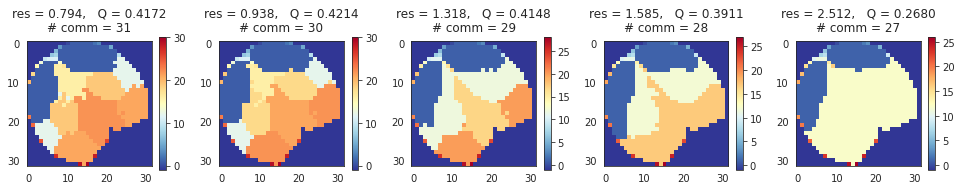

In [668]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(1, len(plot_idxs), figsize=(13.5, 3))

for ii, idx in enumerate(plot_idxs):
    x0, y0 = tuple(zip(*modularities_louvain.items()))
    x1, y1 = tuple(zip(*num_communities_louvain.items()))
    
    partition = community.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat = np.ones((size, size)) * -1
    for node_idx, lbl in labels.items():
        i, j = tuple(map(lambda x: int(x), lbl.split(',')))
        comm_mat[i, j] = partition[node_idx]

    im = axes[ii].imshow(comm_mat, cmap='RdYlBu_r')
    plt.colorbar(im, ax=axes[ii], shrink=0.7)
    msg = 'res = {:.3f},   Q = {:.4f}\n# comm = {:d}'
    msg = msg.format(x0[idx], y0[idx], y1[idx])
    axes[ii].set_title(msg, y=1.03)
    
fig.tight_layout()
plt.show()

In [669]:
partition = community.best_partition(g, resolution=x0[max_mod_idx], random_state=42)

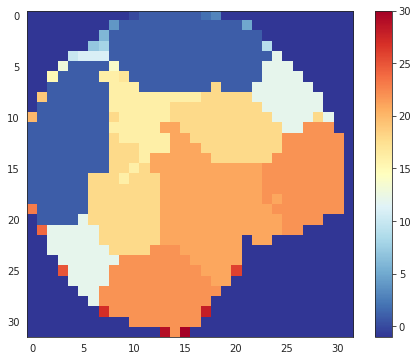

In [671]:
comm_mat = np.ones((size, size)) * -1
for node_idx, lbl in labels.items():
    i, j = tuple(map(lambda x: int(x), lbl.split(',')))
    comm_mat[i, j] = partition[node_idx]

plt.figure(figsize=(8, 6))
plt.imshow(comm_mat, cmap='RdYlBu_r')
plt.colorbar()

In [678]:
coms_ctr = Counter(partition.values())
coms_ctr.most_common()

[(1, 202),
 (22, 135),
 (18, 120),
 (21, 116),
 (12, 68),
 (16, 41),
 (11, 3),
 (0, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (17, 1),
 (19, 1),
 (20, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1)]

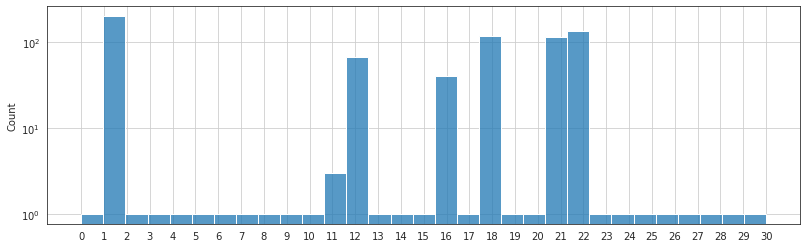

In [686]:
plt.figure(figsize=(13.5, 4))
sns.histplot(list(partition.values()), bins=len(coms_ctr))
plt.yscale('log')
plt.xticks(range(len(coms_ctr)))
plt.grid()
plt.show()

In [699]:
good_com_idxs = tuple(zip(*filter(lambda x: x[1] > 5, coms_ctr.most_common())))[0]
good_com_idxs

(1, 22, 18, 21, 12, 16)

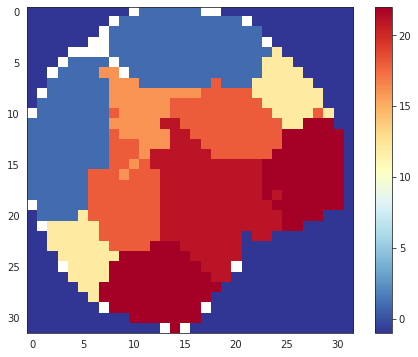

In [700]:
comm_mat = np.ones((size, size)) * -1
for node_idx, lbl in labels.items():
    i, j = tuple(map(lambda x: int(x), lbl.split(',')))
    com_idx = partition[node_idx]
    if com_idx in good_com_idxs:
        comm_mat[i, j] = partition[node_idx]
    else:
        comm_mat[i, j] = np.nan

plt.figure(figsize=(8, 6))
plt.imshow(comm_mat, cmap='RdYlBu_r')
plt.colorbar()

## Even finer resolution

### Downsample

In [616]:
size = 64
widths = [int(np.ceil(item / size)) for item in ca_reduced.shape[:2]]
nt = ca_reduced.shape[-1]

downsampled = np.zeros((size, size, nt))
for i in range(size):
    for j in range(size):
        data = ca_reduced[widths[0]*i: widths[0]*(i+1), widths[1]*j: widths[1]*(j+1), :]
        num_nonzero_mean = sum(abs(data).mean(-1).flatten() != 0)
        
        if num_nonzero_mean > 0:
            downsampled[i, j, :] = data.reshape(-1, nt).sum(0) / num_nonzero_mean
        else:
            downsampled[i, j, :] = 0.

downsampled.shape

(64, 64, 22000)

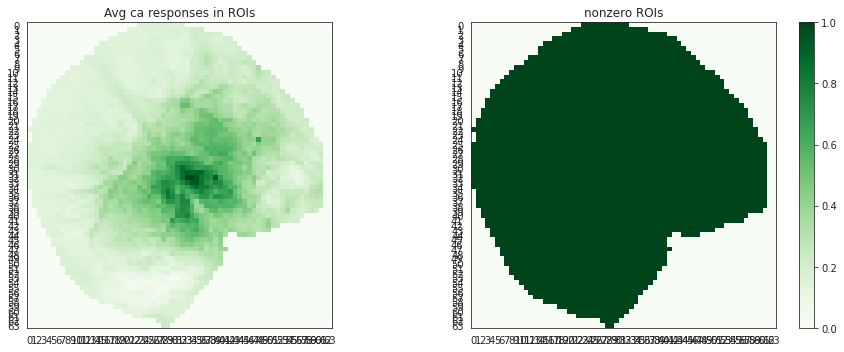

In [617]:
sns.set_style('white')

data = downsampled.mean(-1)

plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.title('Avg ca responses in ROIs')

data[data>0] = 1

plt.subplot(122)
plt.imshow(data, cmap='Greens')
plt.xticks(range(size))
plt.yticks(range(size))
plt.colorbar()
plt.title('nonzero ROIs')

plt.tight_layout()
plt.show()

In [628]:
df = pd.DataFrame()

downsampled_means = abs(downsampled).mean(-1)
dict_list = []
for i in tqdm(range(size), leave=False):
    for j in range(size):
        k = '{:d},{:d}'.format(i, j)
        
        if downsampled_means[i, j] != 0:
            data_dict = {
                'id': [k] * nt,
                't': np.arange(nt),
                'val': downsampled[i, j],
            }
            dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))
df = df.pivot(index='t', columns='id', values='val')
df = df.reindex(sorted(df.columns, key=lambda x: int(x.split(',')[0]) * 1000 + int(x.split(',')[1])), axis=1)

In [629]:
threshold = 0.8

corr = df.corr()
corr[corr<=threshold] = 0.

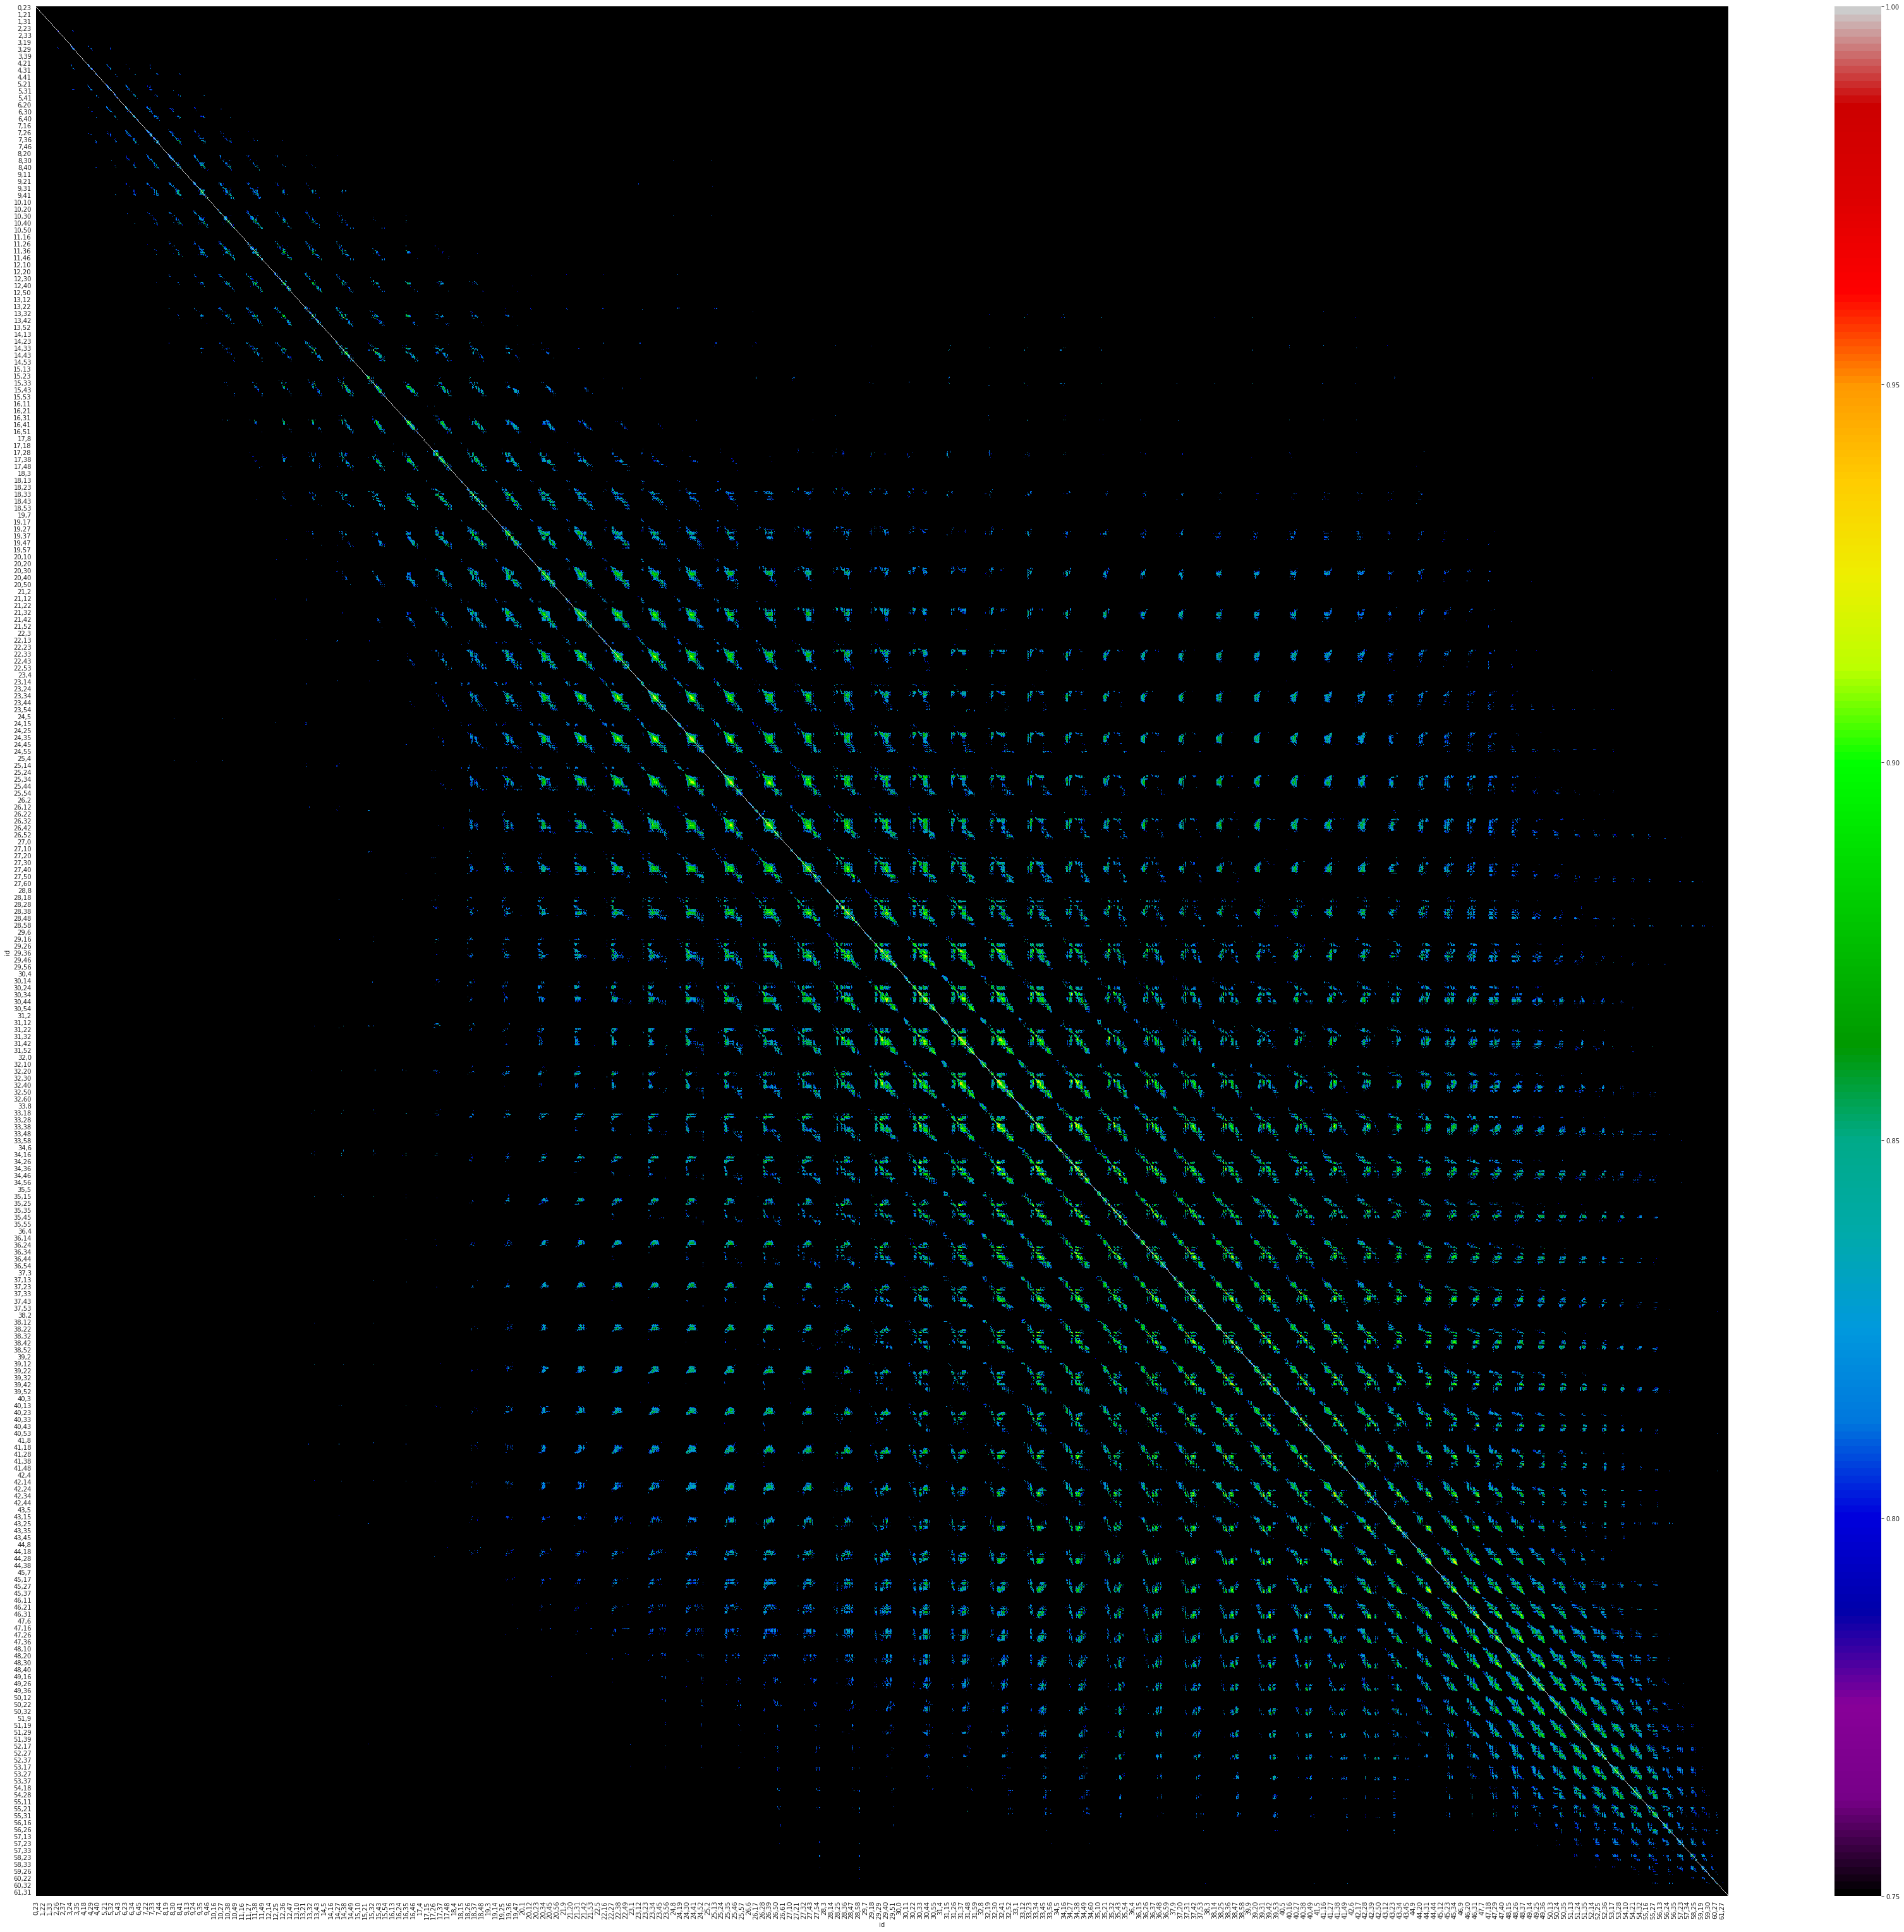

In [630]:
plt.figure(figsize=(60, 55))
sns.heatmap(corr, cmap='nipy_spectral', vmin=threshold-0.05, vmax=1., cbar_kws={'aspect': 40})
plt.yticks(rotation=0);

In [631]:
import networkx as nx
import community
import networkx.algorithms.community as nx_comm
from cdlib import algorithms

In [632]:
labels = labels = df.columns.values.tolist()
labels = {i: lbl for i, lbl in enumerate(labels)}
corr_mat = df.corr().values
corr_mat[corr_mat<threshold] = 0.
np.fill_diagonal(corr_mat, 0.)

g = nx.from_numpy_matrix(corr_mat)
# g = nx.relabel_nodes(g, mapping=)

In [633]:
g.order()

2717

In [634]:
# run algorithm
communities_louvain = {}
max_k = 100

for resolution in tqdm(np.logspace(-1, 1, max_k+1), leave=False):
    coms =  algorithms.louvain(g, resolution=resolution) 
    communities_louvain[resolution] = coms.communities

# process results
modularities_louvain = {}
num_communities_louvain = {}

for resolution, coms_list in communities_louvain.items():
    modularities_louvain[resolution] = nx_comm.modularity(g, communities=coms_list)
    num_communities_louvain[resolution] = len(coms_list)

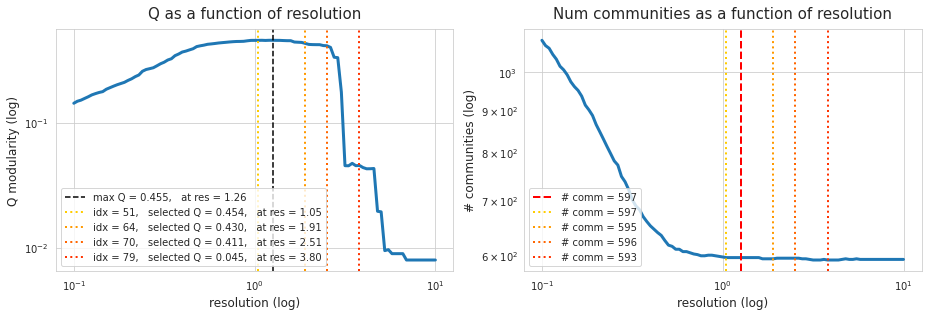

In [636]:
# HIDE CODE


selected_idxs = [51, 64, 70, 79]
palette = sns.color_palette('autumn_r', n_colors=len(selected_idxs))

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')


x0, y0 = tuple(zip(*modularities_louvain.items()))
axes[0].loglog(x0, y0, lw=3)
max_mod_idx = np.argmax(y0)
max_mod = y0[max_mod_idx]
res_at_max_mod = x0[max_mod_idx]
lbl = 'max Q = {:.3f},   at res = {:.2f}'.format(max_mod, res_at_max_mod)
axes[0].axvline(res_at_max_mod, color='k', lw=1.5, ls='--', label=lbl)


for i, _idx in enumerate(selected_idxs):
    lbl = 'idx = {:d},   selected Q = {:.3f},   at res = {:.2f}'.format(_idx, y0[_idx], x0[_idx])
    axes[0].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

x1, y1 = tuple(zip(*num_communities_louvain.items()))
axes[1].loglog(x1, y1, lw=3)
lbl = '# comm = {:d}'.format(y1[max_mod_idx])
axes[1].axvline(res_at_max_mod, color='r', lw=2, ls='--', label=lbl)

for i, _idx in enumerate(selected_idxs):
    lbl = '# comm = {:d}'.format(y1[_idx])
    axes[1].axvline(x0[_idx], color=list(palette)[i], lw=2, ls=':', label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='lower left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='lower left')

fig.tight_layout()
plt.show()

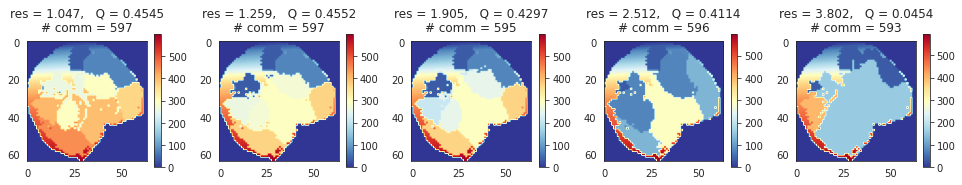

In [637]:
sns.set_style('white')
plot_idxs = sorted(selected_idxs + [max_mod_idx])
fig, axes = plt.subplots(1, len(plot_idxs), figsize=(13.5, 3))

for ii, idx in enumerate(plot_idxs):
    x0, y0 = tuple(zip(*modularities_louvain.items()))
    x1, y1 = tuple(zip(*num_communities_louvain.items()))
    
    partition = community.best_partition(g, resolution=x0[idx], random_state=42)
    comm_mat = np.ones((size, size)) * -1
    for node_idx, lbl in labels.items():
        i, j = tuple(map(lambda x: int(x), lbl.split(',')))
        comm_mat[i, j] = partition[node_idx]

    im = axes[ii].imshow(comm_mat, cmap='RdYlBu_r')
    plt.colorbar(im, ax=axes[ii], shrink=0.7)
    msg = 'res = {:.3f},   Q = {:.4f}\n# comm = {:d}'
    msg = msg.format(x0[idx], y0[idx], y1[idx])
    axes[ii].set_title(msg, y=1.03)
    
fig.tight_layout()
plt.show()

In [646]:
partition = community.best_partition(g, resolution=max_mod_idx, random_state=42)

In [649]:
from collections import Counter
Counter(list(partition.values()))

Counter({0: 1,
         1: 1,
         2: 1,
         3: 1,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 2121,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 1,
         55: 1,
         56: 1,
         57: 1,
         58: 1,
         59: 1,
         60: 1,
         61: 1,
         62: 1,

In [650]:
partition

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 35,
 57: 35,
 58: 35,
 59: 35,
 60: 35,
 61: 35,
 62: 35,
 63: 35,
 64: 55,
 65: 56,
 66: 57,
 67: 58,
 68: 59,
 69: 60,
 70: 61,
 71: 62,
 72: 63,
 73: 64,
 74: 65,
 75: 66,
 76: 67,
 77: 68,
 78: 69,
 79: 70,
 80: 71,
 81: 72,
 82: 73,
 83: 35,
 84: 35,
 85: 35,
 86: 35,
 87: 35,
 88: 35,
 89: 35,
 90: 35,
 91: 35,
 92: 74,
 93: 75,
 94: 76,
 95: 77,
 96: 35,
 97: 35,
 98: 35,
 99: 78,
 100: 35,
 101: 35,
 102: 79,
 103: 80,
 104: 81,
 105: 82,
 106: 83,
 107: 84,
 108: 85,
 109: 86,
 110: 87,
 111: 88,


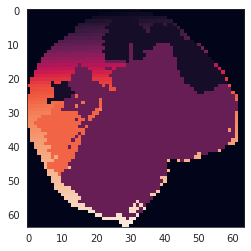

In [651]:
plt.imshow(comm_mat)

## Discussion

...